In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# MNIST

A base de dados que utilizaremos é conhecida como MNIST ("Modified National Institute of Standards and Technology"), e deriva de uma base maior que foi construida pela NIST nos Estados Unidos (o equivalente da nossa ABNT). Esta base de dados é considerada o verdadeiro "Hello, world!" de métodos de classificação. Em http://yann.lecun.com/exdb/mnist/ temos uma descrição mais detalhada desta base de dados.

**Atividade**: 
    
Leia a página de descrição do MNIST supracitada, e responda:

- Quantas imagens de treinamento e quantas imagens de teste existem na MNIST?

- Qual o tamanho de cada imagem no MNIST?

- Os criadores da MNIST tiveram um cuidado especial ao construir os conjuntos de treinamento e teste, em relação às pessoas que escreveram os dígitos. Que cuidado foi esse, e por que foi adotado?

- As imagens foram construidas escaneando digitos manuscritos, que foram escritos por dois grupos de pessoas: alunos de colegial (SD-1) e funcionários da NIST (SD-3). Originalmente a NIST designou SD-3 como o conjunto de teste, e SD-1 como o conjunto de treinamento. Os criadores da MNIST criticaram essa decisão e resolveram misturar os conjuntos. Por que? Como esta situação difere daquela da pergunta anterior?

- A página lista vários artigos que exploraram métodos de classificação no MNIST, com seus respectivos desempenhos. Qual o método com o pior desempenho (e qual foi esse desempenho)? Qual o método com o melhor desempenho, e de quanto foi?

**R:** 

 - 60000
 - 28px x 28px
 - o
 - O conjunto SD-3 era muito mais fácil de identificar do que o SD-1, por tanto o treinamento de um, provavelmente, não seria válido para o outro
 - O pior desempenho foi o classificador linear (12%) e o melhor foi o committee of 35 conv. net, 1-20-P-40-P-150-10 [elastic distortions] (com width normalization) (0.23%)

O scikit-learn já tem ferramentas para baixar e disponibilizar alguns dos datasets mais comuns da comunidade de machine learning:

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

No campo 'data' temos as várias imagens de dígitos manuscritos. Cada item é uma lista de $28^2 = 784$ valores.

No campo 'target' temos o rótulo de cada uma dessas imagens.

In [4]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Vamos ver um desses dígitos manuscritos para checar se a leitura de dados funcionou:

label: 5.0


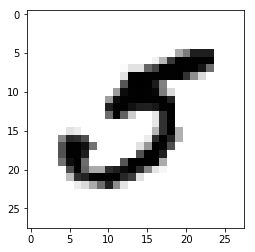

In [5]:
some_digit = X[36000]
some_digit_label = y[36000]

print('label: {}'.format(some_digit_label))

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.show()

Parece que deu certo: pela imagem trata-se de um dígito $5$ manuscrito, e de fato o rótulo confirma essa observação.

# Separando treinamento e teste

Conforme visto na descrição do dataset MNIST, a separação entre conjunto de treinamento e teste já está feita. Neste caso, não devemos fazer a separação dos dados conforme visto na aula passada. Outro ponto notável desta base: os exemplos estão organizados por dígito. Isso é ruim para certos algoritmos de machine learning, vamos resolver esse problema daqui a pouco. Para ilustrar tudo isso, veja como os *labels* estão arranjados:

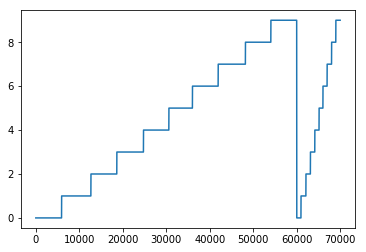

In [6]:
plt.plot(mnist['target'])
plt.show()

**Pergunta:** Qual a faixa de índices dos dígitos $5$ do conjunto de treinamento? Aparentemente é de 30000 a 35999, mas quais são os valores exatos?

**R:**

Os primeiros 60000 exemplos são o conjunto de treinamento, e estão organizados por dígito. Os últimos 10000 exemplos são o conjunto de teste, e também estão organizados por dígito.

In [7]:
X_train = X[:60000]
y_train = y[:60000]

X_test = X[60000:]
y_test = y[60000:]

Vamos ver mais alguns digitos desta base:

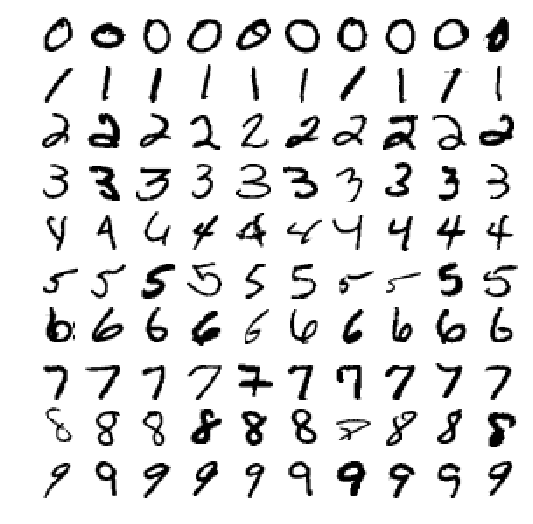

In [8]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)

Alguns classificadores requerem que as amostras de treinamento estejam bem embaralhadas, ao invés de estarem organizadas por classe. Vamos embaralhar o conjunto de treinamento. Note que a mesma permutação que é aplicada à `X_train` deverá ser aplicada à `y_train`

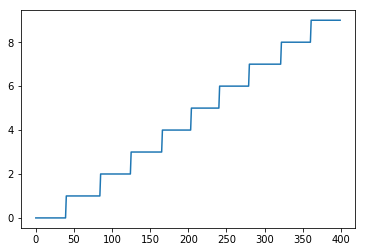

In [9]:
plt.plot(y_train[::150])  # Antes de embaralhar.

In [10]:
shuffle_index = np.random.permutation(60000)
X_train = X_train[shuffle_index]
y_train = y_train[shuffle_index]

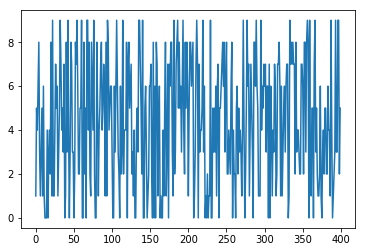

In [11]:
plt.plot(y_train[::150])  # Depois de embaralhar.

# Classificação binária

Vamos começar com um problema mais simples: classificar os dígitos da base em 'cincos' e 'não-cincos'. Este é um problema de classificação binária. Por mera convenção, chamaremos de 'amostras positivas', ou simplemente 'positivos' os digitos $5$ e de 'negativos' os demais dígitos.

Vamos adaptar os conjuntos de treinamento e teste ao nosso cenário:

In [20]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Verificando se funcionou:

In [21]:
n = 20
for original, binarized in zip(y_train[:n], y_train_5[:n]):
    print('{} -> {}'.format(original, binarized))

1.0 -> False
6.0 -> False
6.0 -> False
1.0 -> False
1.0 -> False
8.0 -> False
2.0 -> False
2.0 -> False
1.0 -> False
5.0 -> True
8.0 -> False
3.0 -> False
0.0 -> False
3.0 -> False
7.0 -> False
4.0 -> False
4.0 -> False
7.0 -> False
3.0 -> False
5.0 -> True


Vamos agora treinar um classificador sobre todo o conjunto de treinamento, como fizemos na aula sobre regressão. Vamos usar um classificador chamado de *Stochastic Gradient Descent*, que é uma generalização de alguns tipos diferentes de classificadores mais tradicionais. O scikit-learn tem uma classe que implementa este classificador: `SGDClassifier`. Com os parâmetros default desta classe, o classificador SGD é equivalente a um classificador do tipo "máquina de vetores de suporte linear".

In [22]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=None, random_state=RANDOM_SEED)  # Existe aleatoriedade dentro do SGDClassifier.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Vamos testar o classificador naquele dígito $5$ que a gente tinha visualizado no começo do notebook:

In [23]:
sgd_clf.predict([some_digit])

array([ True])

Perfeito, ele acertou! Mas isso foi apenas um exemplo, vamos agora estudar o desempenho do classificador.

# Métricas de desempenho

## Usando validação cruzada

Assim como na aula anterior, podemos usar a estratégia da validação cruzada para tentar inferir o desempenho do nosso classificador no mundo real:

In [24]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

A medida usada é o *accuracy* (acurácia), que é a porcentagem de acertos de previsão. Obtivemos 96%! Parece excelente, mas será mesmo? Compare com o "classificador" a seguir:

In [25]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        # Nada a ser feito no treinamento.
        pass

    def predict(self, X):
        # Recebe len(X) amostras, chuta "False" como resposta para todas!
        return [False] * len(X)

In [26]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

**Pergunta:** Parece que atingir 90% não é nada difícil neste problema... na verdade, é o esperado! Explique porque.

**R:** pois a chance de um número de 0 a 9 não ser 5 é de 90%

## Matriz de confusão

Uma forma muito interessante de se avaliar o desempenho de um classificador é obter a matriz de confusão (*confusion matrix*) do classificador. Nesta matriz cada linha representa a categoria *verdadeira* de um objeto, e cada coluna representa a categoria *predita* de um objeto. Uma posição $(r,c)$ da matriz de confusão representa, portanto, o número de objetos que pertencem verdadeiramente à categoria $r$, mas que foram classificados como pertencentes à categoria $c$ por nosso classificador. 

![Matriz de confusão](img/confusao.png "Matriz de confusão")

As células da diagonal, em verde, mostram as posições onde a classe verdadeira e a classe predita coincidem, esses são os acertos. As células fora da diagonal, em azul, são os erros.

Podemos calcular a matriz de confusão resultante do treinamento sobre o conjunto (de treinamento) completo:

In [27]:
from sklearn.metrics import confusion_matrix

sgd_clf.fit(X_train, y_train_5)
y_train_pred = sgd_clf.predict(X_train)
mat = confusion_matrix(y_train_5, y_train_pred)
mat

array([[53470,  1109],
       [ 1003,  4418]])

Porém o desempenho exibido por este processo é muito otimista, e não representa uma estimativa realista dos erros deste classificador no mundo real.

**Pergunta:** Em caso de overfitting total, como ficaria a matriz de confusão?

**R:** Ficaria 

[[ 55000,  0000],
 [  0000,  5000]]

Uma idéia melhor é aplicar o conceito de validação cruzada para realizar a predição de cada amostra. Funciona assim:

- Particionamos os dados em N partições.

- Para cada partição:

    - Treinamos o classificador sobre os dados das outras partições
    
    - Usamos o classificador para prever as classes das amostras desta partição

Por exemplo: suponha que temos 3 partições. As categorias preditas dos objetos da primeira partição são obtidas da seguinte forma:

- Treinamos o classificador usando os dados das partições 2 e 3

- Aplicamos o classificador para os objetos da partição 1. Guardamos estes resultados

Fazemos o mesmo para os objetos das partições 2 e 3. Desta forma, cada objeto foi predito de modo "honesto", ou seja, usando um classificador que não continha o próprio objeto como dado de treinamento!

O scikit-learn já tem uma função para fazer exatamente isso: `cross_val_predict`

In [28]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Agora podemos observar uma matriz de confusão mais realista:

In [30]:
mat = confusion_matrix(y_train_5, y_train_pred)
mat

array([[53272,  1307],
       [ 1077,  4344]])

Não mudou muito, mas tudo bem: esses números são mais confiáveis. Significa que nosso modelo não é muito inclinado a ter overfitting nesse problema em particular!

Nesta matriz de confusão a primeira linha indica dígitos "não-cinco", e a segunda linha indica os dígitos "cinco". Em problemas de classificação binária usamos a terminologia "negativos" (os "não-cinco") e "positivos" (os "cinco"), e dizemos também que nosso problema é "detectar" os dígitos "cinco".

- **TP**: Os valores **verdadeiramente positivos** e que foram **preditos como positivos** são os **true positives** (verdadeiros positivos).

- **FP**: Os valores **verdadeiramente positivos** e que foram **preditos como negativos** são os **false negatives** (falsos negativos, pois foram errôneamente classificados como negativos).

- **TN**: Os valores **verdadeiramente negativos** e que foram **preditos como negativos** são os **true negatives** (verdadeiros negativos).

- **FN**: os valores **verdadeiramente negativos** e que foram **preditos como positivos** são os **false positives** (falsos positivos, pois foram errôneamente classificados como positivos).

![Precision-recall](img/precision_recall.png "Precision and recall")

**Perguntas:**

- Dê um exemplo real de falso positivo.

- Dê um exemplo real de falso negativo.

- Nesta matriz exemplo, qual é a acurácia?

**R:**
 - Homem grávido
 - Gravida falhando em teste de gravidez
 - 8/11

## Precision e recall

A medida de acurácia não permite distinguir entre os tipos de erro. Duas medidas mais comuns que são empregadas em machine learning são a **precision** (precisão) e **recall** (revocação), definidas como:

- Precision: Dentre os elementos classificados como positivos, quantos realmente são positivos?

$$\text{precision} = \frac{TP}{TP + FP}$$

- Recall: Dentre os elementos verdadeiramente positivos, quantos foram detectados como positivos?

$$\text{recall} = \frac{TP}{TP + FN}$$

**Perguntas:** 

- É sempre possível construir um classificador com recall 100%. Como? E o que acontece com o precision?

- Qual o precision e o recall do Never5Classifier?

**R:**
 - Sim, classificando todos os valores como positivos. Consequentemente, a precisão dispenca.

Para calcular o precision e o recall no scikit-learn:

In [31]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7687135020350381
0.801328168234643


**Atividade:** Confirme se o scikit-learn acertou baseado na matriz de confusão.

In [36]:
# array([[53272,  1307],
#        [ 1077,  4344]])
print('precision: {}'.format(4344/(4344+1307)))
print('recall: {}'.format(4344/(4344+1077)))

precision: 0.7687135020350381
recall: 0.801328168234643


A métrica $F_1$ serve para combinar o precision e o recall em uma métrica única que valoriza o equilibrio entre estas duas medidas. É definida como a média harmônica do precision e do recall:


$$F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}$$

No scikit-learn:

In [37]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7846820809248555


O valor de $F_1$ tende a favorecer precision e recall balanceados. Isto não é necessariamente bom, existem situações em que você quer favorecer um ou outro.

**Perguntas:**

- Dê um exemplo de situação onde precision é melhor que recall.

- Dê um exemplo de situação onde recall é melhor que precision.

**R:** 
 - Tratamento de doenças por médicos (melhor prevenir do que remediar)
 - Anuncio de doenças para pacientes (ignorância é o melhor remédio)

### Precision/recall tradeoff

Seria muito bom se tivéssemos um classificador com precision 100% e recall 100%, seria um classificador perfeito!

**Atividade:** Prove que nestas condições temos um classificador que não erra.

**Resposta:** A única condição onde isso seria verdadeiro é quando todos os valores não pertencentes a diagonal pricipal seriam 0, ou seja, não existiria erro.

Infelizmente o mundo real não é assim: quanto maior o precision menor o recall, e vice versa. Para entender isso melhor temos que conhecer um pouco mais a fundo como nosso classificador (SGD) funciona.

Dentro do SGDClassifier, o primeiro passo da predição é calcular um valor para a amostra sobre a qual estamos fazendo a predição. Veremos em aulas subsequentes como isso funciona. Quanto maior o valor, mais provável é que a amostra seja positiva. Esta função que se aplica inicialmente chama-se "função de decisão" (decision function). 

Em seguida, usamos um parâmetro do classificador chamado de valor de limiar (threshold). Se o valor da função de decisão estiver acima do threshold, a amostra é classificada como positiva. Caso contrário, será classificada como negativa. 

**Perguntas:**

- O que acontece se o threshold for muito, muito baixo? Como ficam os valores de precision e recall?

- O que acontece se o threshold for muito, muito alto? Como ficam os valores de precision e recall?

**R:**
 - Caso o threshold sej muito baixo, haverão muitos falsos positivos, diminuindo a precisão e aumentando o recall (pela drastica redução no valor de falsos negativos em consequência).
 - Basicamente o contrário, o valor de falso negativos aumenta drasticamente, junto com o recall, enquanto a precisão e os falsos positivos dispencam

Podemos observar os valores da função de decisão calculados para nossas amostras de treinamento usando o scikit-learn: basta adicionar um parâmetro extra à chamada de `cross_val_predict`:

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# Gambiarra para desviar do bug #9589 introduzido no Scikit-Learn 0.19.0:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

Vamos agora plotar os valores de precision e recall juntos em uma curva única:

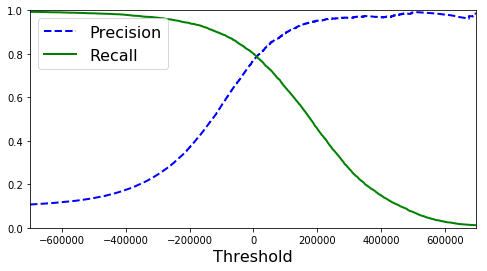

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 4))

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlim([-700000, 700000])
plt.ylim([0, 1])
plt.show()

O que essa curva significa? Significa que podemos ter qualquer valor de precision que quisermos, mas isso mexe no recall, e vice versa! 

Por exemplo: suponha que queremos um precision de 90% - queremos que nosso classificador esteja muito seguro de que achou um dígito 5. Como já temos os valores da função de decisão (`y_scores`), basta aplicar um threshold alto para ter um classificador de alta precisão! Olhando na curva acima, vemos que um threshold de aproximadamente 100000 deve servir:

In [40]:
y_train_pred_90 = (y_scores > 100000)

Vamos medir o precision e o recall deste classificador:

In [41]:
print('Precision: {}'.format(precision_score(y_train_5, y_train_pred_90)))
print('Recall: {}'.format(recall_score(y_train_5, y_train_pred_90)))

Precision: 0.8935031847133758
Recall: 0.646928610957388


Aumentamos o precision para aproximadamente 90%, mas o recall caiu.

Se estivermos interessados em observar apenas o compromisso entre precision e recall, podemos diagramar um contra o outro:

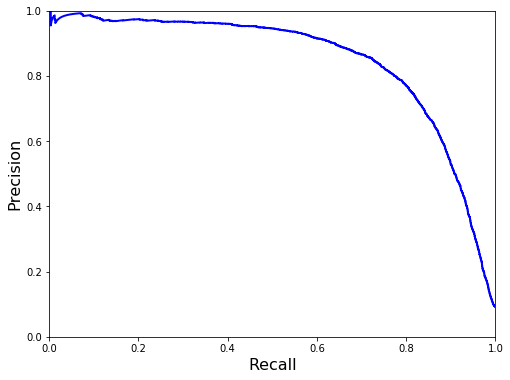

In [42]:
plt.figure(figsize=(8, 6))

plt.plot(recalls, precisions, "b-", linewidth=2)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])

plt.show()

Observe que após recall de 80% o precision cai muito rápido.

**Pergunta:** Alguem chega para você e diz "Meu classificador é o melhor! Tem precision de 99%!". O que você pergunta em seguida?

**R:** Ok, mas qual o recall?

## Sensibilidade, especificidade e curva ROC

Outra ferramenta útil para descrever o desempenho de um classificador binário é a curva de Característica de Operação do Receptor, mais conhecida pelo seu nome em inglês: *Receiver Operating Characterístic (ROC) curve*. É uma curva similar á curva precision-recall, mas usa a razão de falsos positivos (*False Positive Rate - FPR*) no eixo das abscissas, e a razão de positivos verdadeiros (*True Positive Rate - TPR*) no eixo das ordenadas. 

*True Positive Rate* é o mesmo que recall: a fração dos verdadeiros positivos que foram identificados como positivos pelo classificador. Outro nome para esta quantidade é sensibilidade (*sensitivity*). 

$$\text{TPR} = \text{recall} = \text{sensitivity} = \frac{\text{TP}}{\text{P}} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

Em termos simples, *sensitivity* é "de todos os positivos, quantos eu detectei?"

O termo sensibilidade é muito usado na Medicina, em vista da importância da sensitividade no diagnóstico médico.

**Pergunta:** No contexto de um programa de *screening* para detecção precoce do câncer de mama usando mamografias, o que significa alta sensitividade?

**R:** Significa que estou diagnosticando a maioria dos casos positivos como positivos, mas não necessariamente que estou diagnosticando os negativos como negativos (ou seja, apesar do alto valor de verdadeiro-positivos, é capaz que tenha um alto valor de falso-positivos também).

*False Positive Rate* é a fração dos negativos verdadeiros que foram identificados como positivos pelo classificador. 

$$\text{FPR} = \frac{FP}{N} = \frac{FP}{TN + FP}$$

Para entender o FPR, vamos entender outra quantidade que é o *True Negative Rate* (TNR), também conhecida como especificidade (*specificity*). A especificidade é a fração de negativos verdadeiros que foram identificados como negativos pelo classificador.

$$\text{TPR} = \text{specificity} = \frac{TN}{N} = \frac{TN}{TN + FP}$$

Em termos simples, *specificity* é "de todos os negativos, quantos eu corretamente percebi como negativos?"

Combinando as expressões de FPR e TPR, vemos que:

$$\text{FPR} = 1 - \text{specificity}$$

**Perguntas:** 

- Na questão anterior vimos que um programa de *screening* para câncer de mama deve ter alta sensitividade, para não ignorar mulheres (apesar de que homem tem câncer de mama também!) que estejam desenvolvendo a doença. Porém, com grande sensitividade vem baixa especificidade! O que acontece se for recomendado mastectomia em todos os casos detectados pelo *screening*?

- Normalmente, após uma detecção via *screening* a mulher é encaminhada para exames posteriores, incluindo biópsia. Em termos de sensibilidade e especificidade, o que esperamos de uma biópsia?

**R:** 
 - O método perde sua credibilidade, uma vez que retorna todos os resultaods como verdadeiros
 - Esperamos uma maior especificidade, para contrastar o valor de alta sensibilidade do *screening*.

A curva ROC representa todos os pares (FPR, TPR) de um classificador binário que trabalhe com função de decisão.

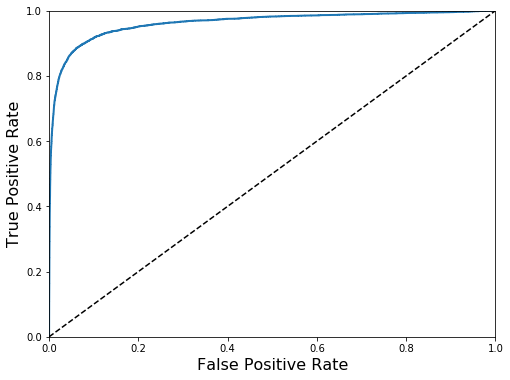

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()

Quando escolhemos um valor específico de threshold para nosso classificador fixamos o ponto de trabalho deste na curva ROC. 

**Pergunta:** Um classificador perfeito opera em qual ponto do espaço (FPR, TPR)?

**R:** (0, 1)

O que acontece com um classificador aleatório (decide ao acaso o valor da função de decisão)? Este classificador terá uma curva ROC como a linha tracejada acima. Qualquer classificador melhor que aleatório terá uma curva ROC acima da linha tracejada.

Vamos trocar de classificador e ver o que acontece:

In [44]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# Gambiarra para desviar do bug #9589 introduzido no Scikit-Learn 0.19.0:
y_scores_forest = y_probas_forest[:, 1]  # score = prob. de ser da classe positiva

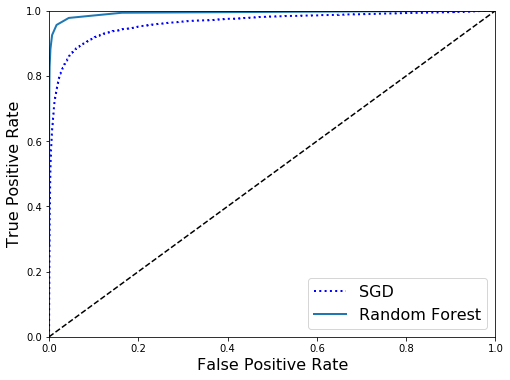

In [45]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.show()

Note que o classificador RandomForest apresenta TPR mais alto para um mesmo FPR do que o SGD. Com isso, parece que o RandomForest tem melhor desempenho que o SGD.

Para sumarizar o desempenho de um classificador binário em apenas um número, usamos a área sob a curva ROC (ROC AUC - Area Under the Curve - score). 

**Perguntas:** 

- Qual o valor do ROC AUC score para o classificador aleatório?

- Qual o valor do ROC AUC score para um classificador perfeito?

**R:** 
 - 1/2
 - 1

Vamos então comparar os escores ROC AUC dos dois classificadores:

In [46]:
from sklearn.metrics import roc_auc_score

print('SGD: {:4f}'.format(roc_auc_score(y_train_5, y_scores)))
print('RandomForest: {:4f}'.format(roc_auc_score(y_train_5, y_scores_forest)))

SGD: 0.962450
RandomForest: 0.993124


RandomForest é um classificador melhor do que SGD neste problema.

**Atividades:** Faça os problemas 1 e 2 do capítulo 3 do livro texto (Géron).

**Desafio:** Problema 4 do livro texto (Géron)!